In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

import scipy.stats as stats
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [2]:
dataset = boston_dataset = datasets.load_boston()

X_df = pd.DataFrame(boston_dataset.data)
X_fn = boston_dataset.feature_names
X_df.columns = X_fn

X_df = X_df.drop(['CHAS'], axis = 1)

y_df = pd.DataFrame(boston_dataset.target)
y_df.columns = ['MEDV']

# 1. Data Preprocessing

## 1.1 Features Scaling

https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

In [3]:
# features scaling is required in many ML algorithm, including PCA
# in general, it is required for the algorithms dealing with the VARIANCE
# of the data or the DISTANCE between data in the features space, such as:

# 1) Ridge, Lasso (variance)
# 2) PCA (variance)
# 3) Neural Networks - Gradient Descent (variance)
# 4) K-Means (distance)
# 5) KNN (distance)

# for this algorithms it is importance that the variance of each feature
# is homogenous, in order to avoid that some features are dominant respect to the other

# ex: feature X1 = [0, 25, 50, 75, 100]
#     features X2 = [0, 0.25, 0.50, 0.75, 1.0]

# the absolute variance for X1 is 100 times the absolute variance of X2, but the relative variance is the same
# if we don't scale the data, since X1 is 100 times X2, X1 will be dominant in algorithms where the variance 
# is an important statistical variable, or algorithms dealing with the distance in the features space.


# features scaling is NOT required in algorithm dealing with DECISION RULES:

# 1) Classification and Regression Trees (CART)
# 2) Random Forest
# 3) Gradient Boosting Decision Trees (GBDTs)

In [4]:
#scaler = MinMaxScaler()
scaler = StandardScaler()

def get_scaled_df(X_df,scaler):
    
    X_scaled = scaler.fit_transform(X_df.values)

    X_df_scaled = pd.DataFrame(X_scaled)

    X_df_scaled.columns = X_df.columns
    
    return X_df_scaled

X_scaled = get_scaled_df(X_df,scaler)
y = y_df

## 1.2 Outliers Removal

<AxesSubplot:>

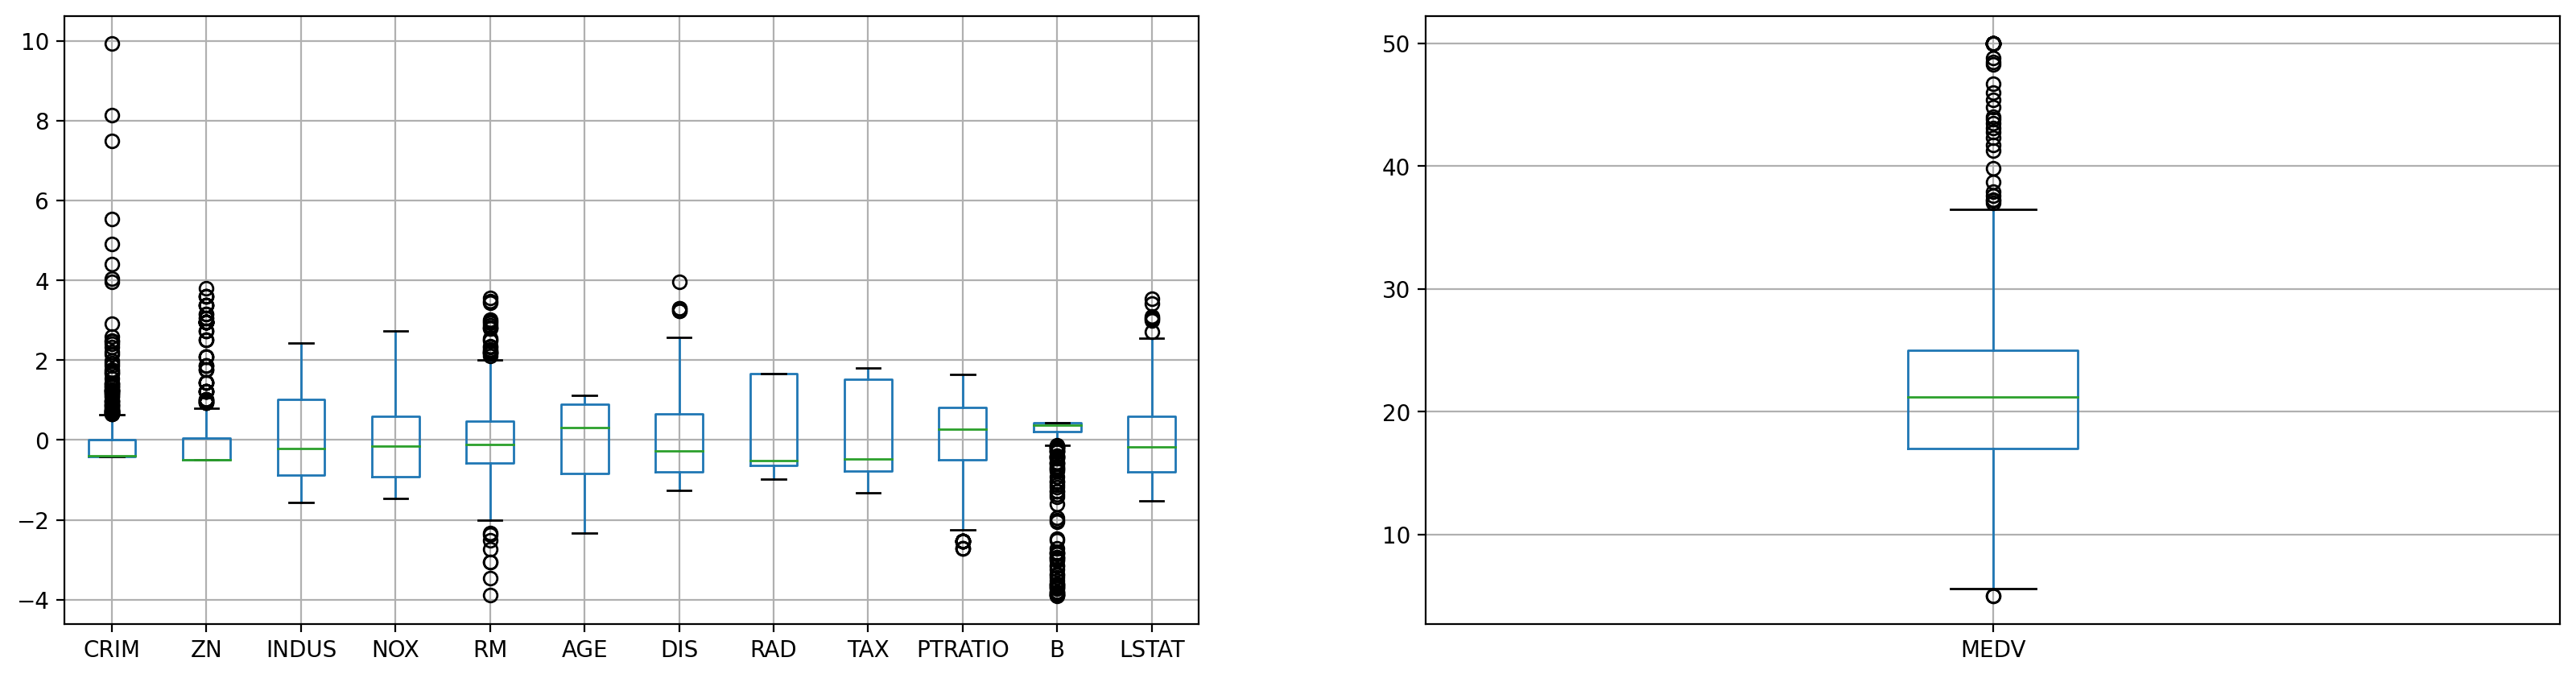

In [5]:
# data distribution after scaling

fig = plt.figure(figsize = (20,5), dpi = 200)

ax = fig.add_subplot(1,2,1)
X_scaled.boxplot()

ax = fig.add_subplot(1,2,2)
y.boxplot()

In [6]:
# function to remove the outliers from the dataset (data which fall outside of the whiskers in the box plot)
# the outliers are removed for each feature separately. It can happen that data that are outliers
# for a certain feature are not outliers for another feature. 
# The threshold to consider data outliers or not is defined by q. 

# upper quartile or 75h percentile (Q3): value for which 75% of the data are less than this value (upper threshold of the box)
# lower quartile or 25th percentile (Q1): value for which 25% of the data are less than this value (lower theshold of the box)
# iqr: distance between the upper and lower quartile: Q3 - Q1

# upper whisker: Q3 + q*iqr
# lower whisler: Q1 - q*iqr

# data > upper whisker or < lower whisker : outliers

# q controls the amount of data to consider as outliers

def get_remove_outliers(X_df,y_df,q):
    
    data = np.column_stack((X_df.values,y_df.values))
    
    for j in range(data.shape[1]):
    
        median = np.median(data[:,j])
        
        upper_quartile = np.percentile(data[:,j], 75)
        lower_quartile = np.percentile(data[:,j], 25)

        iqr = upper_quartile - lower_quartile
        upper_whisker = (data[:,j][data[:,j] <= upper_quartile + q * iqr]).max()
        lower_whisker = (data[:,j][data[:,j] >= lower_quartile - q * iqr]).min()
        
        data_clean = data[data[:,j] <= upper_whisker]
        data_clean = data_clean[data_clean[:,j] >= lower_whisker]
        
        data = data_clean
        
        
    X_df_clean = pd.DataFrame(data_clean[:,:data_clean.shape[1] - 1])
    X_df_clean.columns = X_df.columns
    
    y_df_clean = pd.DataFrame(data_clean[:,data_clean.shape[1] - 1])
    y_df_clean.columns = y_df.columns
    
    return X_df_clean,y_df_clean

In [7]:
q = 3

X_scaled_clean, y_clean = get_remove_outliers(X_scaled,y, q)

fraction_removed_outliers =  1 - X_scaled_clean.shape[0] / X_scaled.shape[0]

print('Removed {:.1f} % data'.format(fraction_removed_outliers * 100))

Removed 33.8 % data


Text(0.5, 1.0, 'y after removing outliers')

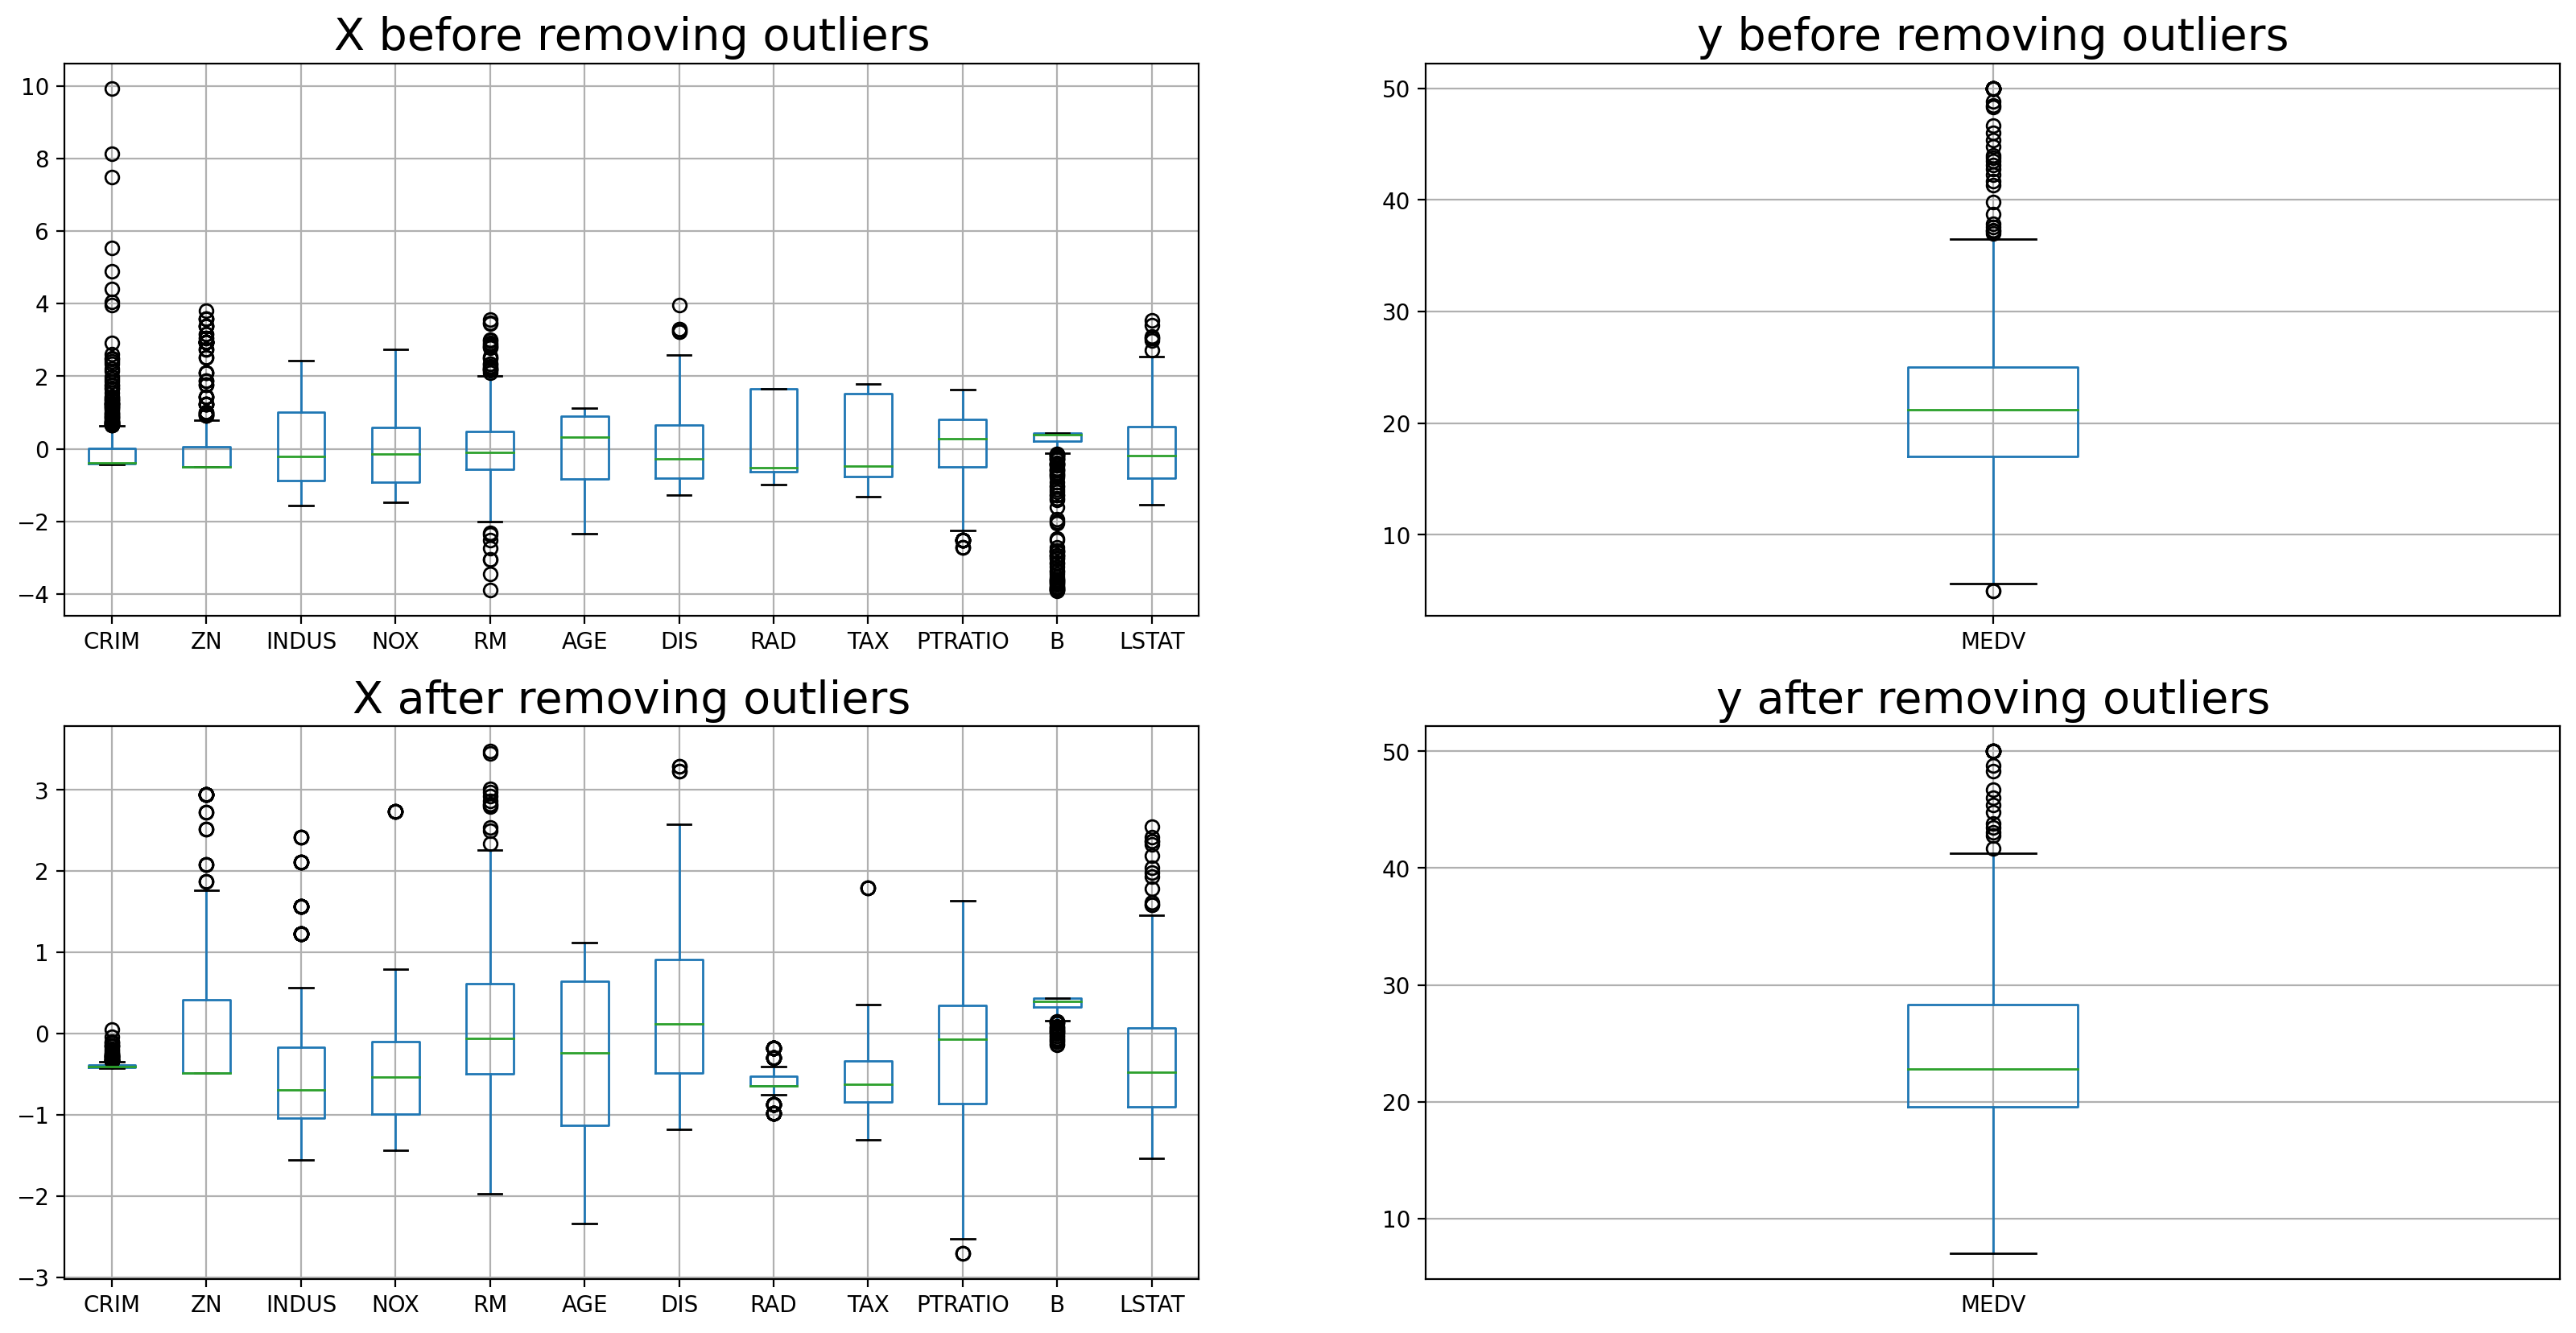

In [8]:
# data distribution after removing outliers

fig = plt.figure(figsize = (20,10), dpi = 200)

ax = fig.add_subplot(2,2,1)
X_scaled.boxplot()
plt.title('X before removing outliers', fontsize = 20)

ax = fig.add_subplot(2,2,2)
y.boxplot()
plt.title('y before removing outliers', fontsize = 20)

ax = fig.add_subplot(2,2,3)
X_scaled_clean.boxplot()
plt.title('X after removing outliers', fontsize = 20)

ax = fig.add_subplot(2,2,4)
y_clean.boxplot()
plt.title('y after removing outliers', fontsize = 20)

# 2. PCA applied

In [46]:
def get_pca(X, n_components):

    pca = PCA(n_components = n_components)

    pca.fit(X)

    X_pca = pca.fit_transform(X)

    X_pca = pd.DataFrame(X_pca)
    
    fn = []
    
    for i in range(n_components):
        
        fn.append('component ' + str(i + 1))
        
    X_pca.columns = fn
    
    pve = pca.explained_variance_ratio_
    
    for i in range(n_components):
    
        print('PVE component {}: {:.1f} %'.format(i + 1, pve[i] * 100))
    print('Cumulative PVE: {:.1f} %'.format(sum(pve)*100))
    
    return X_pca, pca, pve


In [49]:
# n_components

# number of principal components used to transform the dataset

# 1st PC: z_i1 = phi_11 * x_i1 + phi_21 * x_i2 + phi_31 * x_i3 + ... + phi_p1 * x_ip

# with max(1/n * sum_n (z_i1 ** 2)) subjected to sum_p (phi_j1 ** 2) =1

# 2nd PC: z_i2 = phi_12 * x_i1 + phi_22 * x_i2 + phi_32 * x_i3 + ... + phi_p2 * x_ip

# with max(1/n * sum_n (z_i2 ** 2)) subjected to sum_p (phi_j2 ** 2) = 1 and Z1 perpendicular Z2


# z_1m, z2m, ..., znm : scores of the component m
# phi_m = [phi_1m, phi_2m, ..., phi_pm] : loading vector of the component m

# in this example we set n_components = 2, but this value must be found using 
# the scree plot of the cumulative PVE

n_components = 6

X_pca, pca, pve = get_pca(X_scaled_clean,n_components)

X_pca

PVE component 1: 44.4 %
PVE component 2: 20.0 %
PVE component 3: 11.9 %
PVE component 4: 6.9 %
PVE component 5: 6.4 %
PVE component 6: 3.6 %
Cumulative PVE: 93.2 %


,component 1,component 2,component 3,component 4,component 5,component 6
0,-0.689421,1.273476,0.349017,-0.603866,-0.043168,0.321974
1,0.103374,0.130653,-0.362747,-0.608763,-0.401610,-0.461662
2,-0.653540,0.800595,-1.116283,-0.171940,0.054525,-0.560679
3,-1.370419,0.139067,-1.350659,-0.569311,0.039327,-0.406677
4,-1.175646,0.257657,-1.306888,-0.581876,-0.286431,-0.538384
...,...,...,...,...,...,...
330,1.251633,-0.178941,-1.292737,0.499290,0.011722,0.496118
331,1.536583,-0.466534,-1.051723,0.324754,-0.048864,0.681280
332,1.366794,0.520282,-1.769917,0.713650,-0.494742,0.356312
333,1.389431,0.287388,-1.593864,0.625640,-0.456908,0.348960


In [50]:
# the biplot illustrates the loading vectors of each features and 
# the data plotted in the principal component space

# in an element phi_jm of the loading vector phi_m of the feature m associated with the feature j
# has a high positive value, it means that the feature j has a high contribution to the component m


def get_biplot(X_pca,comp_ax_hor,comp_ax_ver,features_names):
    
    score = X_pca.values
    coeff = np.transpose(pca.components_[[comp_ax_hor-1,comp_ax_ver-1], :])
    
    
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    fig = plt.figure(figsize = (10,10))
    plt.scatter(xs * scalex,ys * scaley,s=5)
    plt.xlabel('Component {}'.format(comp_ax_hor))
    plt.ylabel('Component {}'.format(comp_ax_ver))
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if features_names is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, features_names[i], color = 'g', ha = 'center', va = 'center')

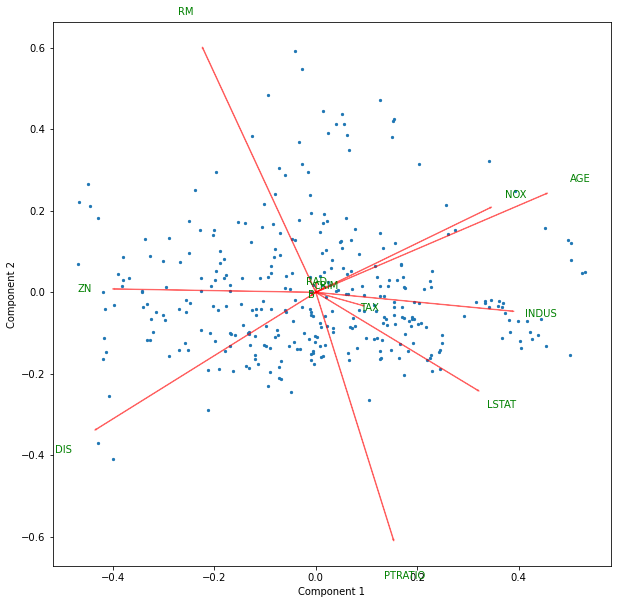

In [51]:
comp_ax_hor = 1

comp_ax_ver = 2

features_names = X_scaled_clean.columns

get_biplot(X_pca,comp_ax_hor, comp_ax_ver, features_names )

ex. with 2 component:

1) **NOX, AGE, INDUS and LSTAT** have all a high positive value in their corresponding elements in the loading vector 
 of the component 1, so it means that they have a **HIGH contribution to the component 1**
 
2) In addition, **NOX, AGE, INDUS and LSTAT** have close loading vectors in both components, meaning that they are **highly correlated**

3) **RM, ZN, DIS** have all a high negative value in their corresponding elements in the loading vector 
of the component 1, so it means that they have a **LOW contribution to the component 1**

4) **RM** has a high value in its element in the loading vector of component 2, so it means that it has a **HIGH contribution to the component 2**

5) **RAD** and **CRIM** have very low values in both component, meaning they have **NO contribution to components 1 and 2**

6) **RAD** and **CRIM** have very close loading vectors, meaning that they are **highly correlated**

Text(0.5, 1.0, 'X before removing outliers')

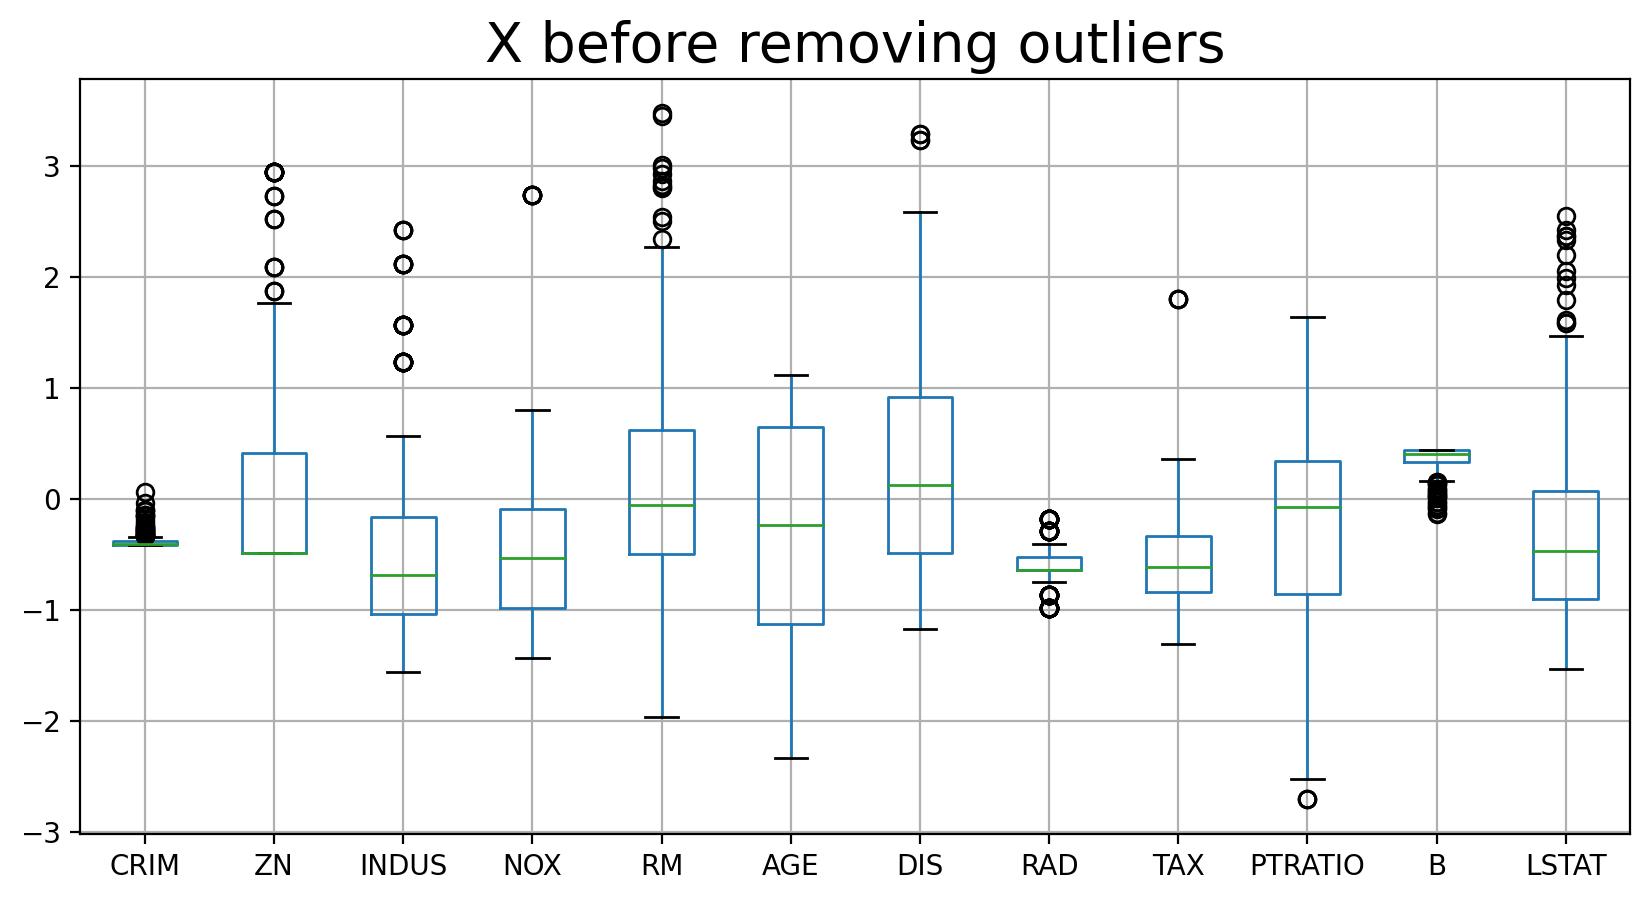

In [52]:
fig = plt.figure(figsize = (10,5), dpi = 200)

ax = fig.add_subplot(1,1,1)
X_scaled_clean.boxplot()
plt.title('X before removing outliers', fontsize = 20)

The biplot confirms the **low variance** of **CRIM, RAD and B (extremely low values in the first and second components** verified also in the **box plot** (after outliers removal)

## 2.1 Comparison PCA, Backward Selection and LASSO

In [53]:
# define a fucntion to perform backward selection

def backward_selection(X,y,alpha):
    
    # alpha: level of significance
    
    # set max p value to an arbitrary high number
    p_max = 1000
    
    # loop until max p value is higher than level of significance
    while (p_max > alpha):
    
        # fit the anove
        X_ANOVA = sm.add_constant(X)

        regressor_ANOVA = sm.OLS(endog = y,exog = X_ANOVA).fit()
        
        # get the p-values
        p_values = regressor_ANOVA.pvalues
    
        # find the max p value
        p_max = np.max(p_values)
   
        
        # drop the feature with the highest p-value
        p_max_index = np.where(p_values == p_max)[0][0]
        
        if p_max_index > 0:
            
            X = X.drop([X.columns[p_max_index - 1]], axis = 1)
                
    return X, regressor_ANOVA

# function to perform LASSO
def get_lasso_dataset(X,y, alpha):
    
    lasso = Lasso( alpha = alpha)
    
    lasso.fit(X,y)
    
    
    features_lasso = []

    for i in range(X.shape[1]):

        B_lasso = lasso.coef_[i]
    
        if B_lasso != 0:
            
            features_lasso.append(X.columns[i])
        
    X_lasso = X[features_lasso]
    
    return X_lasso

     

In [54]:
alpha = 0.05   # significance level

X_bs, anova = backward_selection(X_scaled_clean, y_clean, alpha)

X_bs

,CRIM,NOX,RM,AGE,DIS,TAX,PTRATIO
0,-0.419782,-0.144217,0.413672,-0.120013,0.140214,-0.666608,-1.459000
1,-0.417339,-0.740262,0.194274,0.367166,0.557160,-0.987329,-0.303094
2,-0.417342,-0.740262,1.282714,-0.265812,0.557160,-0.987329,-0.303094
3,-0.416750,-0.835284,1.016303,-0.809889,1.077737,-1.106115,0.113032
4,-0.412482,-0.835284,1.228577,-0.511180,1.077737,-1.106115,0.113032
...,...,...,...,...,...,...,...
330,-0.413229,0.158124,0.439316,0.018673,-0.625796,-0.803212,1.176466
331,-0.415249,0.158124,-0.234548,0.288933,-0.716639,-0.803212,1.176466
332,-0.413447,0.158124,0.984960,0.797449,-0.773684,-0.803212,1.176466
333,-0.407764,0.158124,0.725672,0.736996,-0.668437,-0.803212,1.176466


In [55]:
alpha = 0.5 # shrinkage coefficient for Lasso 
            #  L =  sum_i(yi - B0 - sum_j (BjXj)) + alpha * sum_j (|Bj|)

X_lasso = get_lasso_dataset(X_scaled_clean, y_clean, alpha = alpha)

X_lasso

,RM,AGE,DIS,PTRATIO,LSTAT
0,0.413672,-0.120013,0.140214,-1.459000,-1.075562
1,0.194274,0.367166,0.557160,-0.303094,-0.492439
2,1.282714,-0.265812,0.557160,-0.303094,-1.208727
3,1.016303,-0.809889,1.077737,0.113032,-1.361517
4,1.228577,-0.511180,1.077737,0.113032,-1.026501
...,...,...,...,...,...
330,0.439316,0.018673,-0.625796,1.176466,-0.418147
331,-0.234548,0.288933,-0.716639,1.176466,-0.500850
332,0.984960,0.797449,-0.773684,1.176466,-0.983048
333,0.725672,0.736996,-0.668437,1.176466,-0.865302


1) The **bivariate plot** shows that **NOX, AGE, INDUS and LSTAT** are correlated (in particular **NOX** and **AGE**)

   For this reason:
   
   **backward selection** (p-values based) has filtered  **NOX, INDUS and LSTAT**, keeping only **AGE**
   
   **LASSO** (shrinkage) has filtered **NOX and INDUS**, keeping only **AGE** and **LSTAT** (that are not strongly correlated like **NOX** and **AGE**)
   
   
2) The **bivariate plot** shows that **CRIME and RAD** are highly correlated and they don't have a significant variance:
    
   For this reason:
    
   **backward selection** (p-values based) has filtered **RAD** keepo=ing only **CRIME** (highly correlated)
    
   **LASSO** (shrinkage) has filtered both of them (very low variance)
    
3) The **bivariate plot** shows that **TAX** has a low variance:

   For this reason:
   
   **LASSO** (shrinkage) has filtered it

4) The **bivariate plot** shows that **RM, DIS and PTRATIO** are not correlated to each other. 

   For this reason:]
   
   **backward selection** (p-values based) have retained them
   
   **LASSO** (shrinkage) have retained them
   

## 2.2 Find the optimal number of components

In [56]:
n_components = np.arange(2,11)


def get_scree_plot(X,n_components):
    
    cumulative_pve = np.zeros((len(n_components)))
    
    for i,n in enumerate(n_components):
        
        _, _, pve = get_pca(X,n)
        print('')
        
        cumulative_pve[i] += 100 * sum(pve)
        
    fig = plt.figure(figsize = (5,5))
        
    plt.plot(n_components, cumulative_pve,'bo-')
    plt.xlabel('N. components')
    plt.ylabel('Cumulative PVE')
        
        
        
        
        

PVE component 1: 44.4 %
PVE component 2: 20.0 %
Cumulative PVE: 64.4 %

PVE component 1: 44.4 %
PVE component 2: 20.0 %
PVE component 3: 11.9 %
Cumulative PVE: 76.3 %

PVE component 1: 44.4 %
PVE component 2: 20.0 %
PVE component 3: 11.9 %
PVE component 4: 6.9 %
Cumulative PVE: 83.2 %

PVE component 1: 44.4 %
PVE component 2: 20.0 %
PVE component 3: 11.9 %
PVE component 4: 6.9 %
PVE component 5: 6.4 %
Cumulative PVE: 89.6 %

PVE component 1: 44.4 %
PVE component 2: 20.0 %
PVE component 3: 11.9 %
PVE component 4: 6.9 %
PVE component 5: 6.4 %
PVE component 6: 3.6 %
Cumulative PVE: 93.2 %

PVE component 1: 44.4 %
PVE component 2: 20.0 %
PVE component 3: 11.9 %
PVE component 4: 6.9 %
PVE component 5: 6.4 %
PVE component 6: 3.6 %
PVE component 7: 2.4 %
Cumulative PVE: 95.6 %

PVE component 1: 44.4 %
PVE component 2: 20.0 %
PVE component 3: 11.9 %
PVE component 4: 6.9 %
PVE component 5: 6.4 %
PVE component 6: 3.6 %
PVE component 7: 2.4 %
PVE component 8: 1.9 %
Cumulative PVE: 97.5 %

PVE com

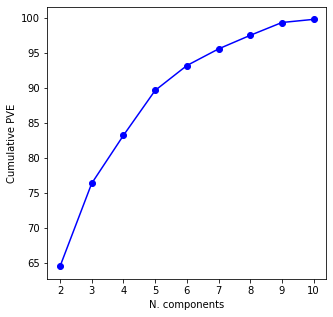

In [57]:
get_scree_plot(X_scaled_clean,n_components)

With **6 components** we can retain ~93% of the variance

Comparing with **Backward Selection** and **LASSO**, ~ 6 is also the number of features we found by p-values  (Backward Selection) and shrinkage (LASSO) features selection methods, revealing a further analogy with the three different dimensionality reduction techniques.

In [58]:
n_components = 6

X_pca, pca, pve = get_pca(X_scaled_clean,n_components)

PVE component 1: 44.4 %
PVE component 2: 20.0 %
PVE component 3: 11.9 %
PVE component 4: 6.9 %
PVE component 5: 6.4 %
PVE component 6: 3.6 %
Cumulative PVE: 93.2 %


In [59]:
X_pca

,component 1,component 2,component 3,component 4,component 5,component 6
0,-0.689421,1.273476,0.349017,-0.603866,-0.043168,0.321974
1,0.103374,0.130653,-0.362747,-0.608763,-0.401610,-0.461662
2,-0.653540,0.800595,-1.116283,-0.171940,0.054525,-0.560679
3,-1.370419,0.139067,-1.350659,-0.569311,0.039327,-0.406677
4,-1.175646,0.257657,-1.306888,-0.581876,-0.286431,-0.538384
...,...,...,...,...,...,...
330,1.251633,-0.178941,-1.292737,0.499290,0.011722,0.496118
331,1.536583,-0.466534,-1.051723,0.324754,-0.048864,0.681280
332,1.366794,0.520282,-1.769917,0.713650,-0.494742,0.356312
333,1.389431,0.287388,-1.593864,0.625640,-0.456908,0.348960


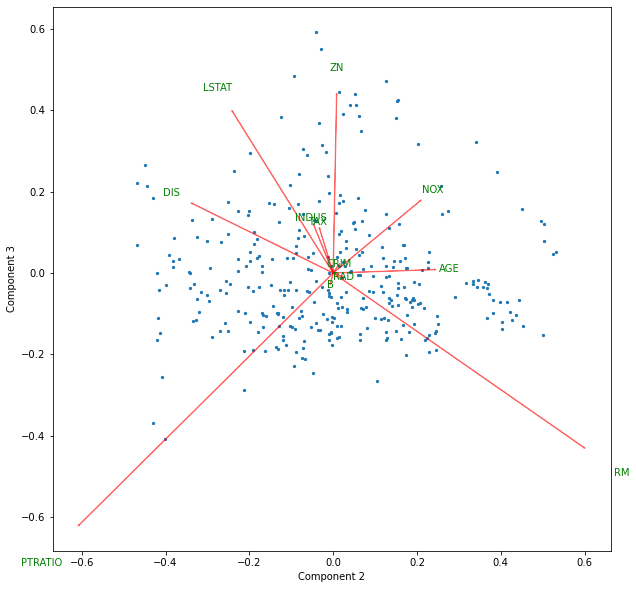

In [60]:
comp_ax_hor = 2

comp_ax_ver = 3

features_names = X_scaled_clean.columns

get_biplot(X_pca,comp_ax_hor, comp_ax_ver, features_names)

## 2.3 Fitting Linear Regression on PC

In [61]:
# function to calculate the adjusted R2 and evaluate the performance of LR

def get_adj_R2(model,X,y):
    
    R2 = model.score(X,y)
    
    n = X.shape[0]
    p = X.shape[1]
    
    adj_R2 = 1 - (1 - R2)*(n - 1)/(n - p - 1)

    return adj_R2

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,y_clean, test_size = 0.33, random_state=42)


lr = LinearRegression()

lr.fit(X_train,y_train)

adj_R2_train = get_adj_R2(lr, X_train, y_train)
adj_R2_test = get_adj_R2(lr,X_test, y_test)

print('Train adj R2 score: {:.3f}'.format(adj_R2_train))
print('Test adj R2 score: {:.3f}'.format(adj_R2_test))

Train adj R2 score: 0.839
Test adj R2 score: 0.738


## 2.4 PCA with Poly Features

**Main Idea:** add non-linear features to the dataset and then extract the principal components from the non-linear features

In [63]:
from sklearn.preprocessing import PolynomialFeatures

def PolynomialFeatures_labeled(input_df,degree, constant):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 
    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)
    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(degree)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_
    
    if not constant:
        output_nparray = output_nparray[:,1:]

        powers_nparray = powers_nparray[1:,:]
        
        index = 0


    input_feature_names = list(input_df.columns)
   
    target_feature_names = []
    
    if constant:
        
        target_feature_names = ["Constant Term"]
        index = 1
        
    for feature_distillation in powers_nparray[index :]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
        
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    
    return output_df

PVE component 1: 34.1 %
PVE component 2: 13.9 %
Cumulative PVE: 47.9 %

PVE component 1: 34.1 %
PVE component 2: 13.9 %
PVE component 3: 11.6 %
Cumulative PVE: 59.5 %

PVE component 1: 34.1 %
PVE component 2: 13.9 %
PVE component 3: 11.6 %
PVE component 4: 8.2 %
Cumulative PVE: 67.7 %

PVE component 1: 34.1 %
PVE component 2: 13.9 %
PVE component 3: 11.6 %
PVE component 4: 8.2 %
PVE component 5: 4.5 %
Cumulative PVE: 72.3 %

PVE component 1: 34.1 %
PVE component 2: 13.9 %
PVE component 3: 11.6 %
PVE component 4: 8.2 %
PVE component 5: 4.5 %
PVE component 6: 4.0 %
Cumulative PVE: 76.3 %

PVE component 1: 34.1 %
PVE component 2: 13.9 %
PVE component 3: 11.6 %
PVE component 4: 8.2 %
PVE component 5: 4.5 %
PVE component 6: 4.0 %
PVE component 7: 3.0 %
Cumulative PVE: 79.3 %

PVE component 1: 34.1 %
PVE component 2: 13.9 %
PVE component 3: 11.6 %
PVE component 4: 8.2 %
PVE component 5: 4.5 %
PVE component 6: 4.0 %
PVE component 7: 3.0 %
PVE component 8: 2.6 %
Cumulative PVE: 81.9 %

PVE com

PVE component 1: 34.1 %
PVE component 2: 13.9 %
PVE component 3: 11.6 %
PVE component 4: 8.2 %
PVE component 5: 4.5 %
PVE component 6: 4.0 %
PVE component 7: 3.0 %
PVE component 8: 2.6 %
PVE component 9: 2.2 %
PVE component 10: 1.8 %
PVE component 11: 1.3 %
PVE component 12: 1.1 %
PVE component 13: 1.0 %
PVE component 14: 1.0 %
PVE component 15: 0.8 %
PVE component 16: 0.7 %
PVE component 17: 0.7 %
PVE component 18: 0.5 %
PVE component 19: 0.5 %
PVE component 20: 0.4 %
PVE component 21: 0.4 %
PVE component 22: 0.4 %
PVE component 23: 0.3 %
PVE component 24: 0.3 %
PVE component 25: 0.3 %
PVE component 26: 0.3 %
PVE component 27: 0.2 %
PVE component 28: 0.2 %
Cumulative PVE: 96.3 %

PVE component 1: 34.1 %
PVE component 2: 13.9 %
PVE component 3: 11.6 %
PVE component 4: 8.2 %
PVE component 5: 4.5 %
PVE component 6: 4.0 %
PVE component 7: 3.0 %
PVE component 8: 2.6 %
PVE component 9: 2.2 %
PVE component 10: 1.8 %
PVE component 11: 1.3 %
PVE component 12: 1.1 %
PVE component 13: 1.0 %
PVE 

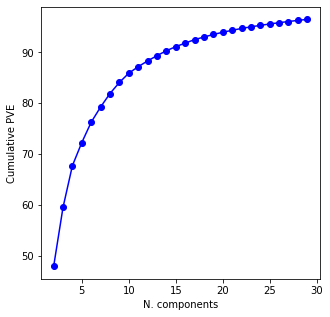

In [71]:
X_poly = PolynomialFeatures_labeled(X_scaled_clean, degree = 3, constant = True)


n_components = np.arange(2,30)


get_scree_plot(X_poly, n_components)



In [72]:
n_components = 20

X_poly_pca, poly_pca, poly_pve = get_pca(X_poly, n_components)


X_train, X_test, y_train, y_test = train_test_split(X_poly_pca,y_clean, test_size = 0.33, random_state = 42)

lr = LinearRegression()

lr.fit(X_train,y_train)

adj_R2_train = get_adj_R2(lr, X_train, y_train)
adj_R2_test = get_adj_R2(lr,X_test, y_test)

print('')
print('Train adj R2 score: {:.3f}'.format(adj_R2_train))
print('Test adj R2 score: {:.3f}'.format(adj_R2_test))

PVE component 1: 34.1 %
PVE component 2: 13.9 %
PVE component 3: 11.6 %
PVE component 4: 8.2 %
PVE component 5: 4.5 %
PVE component 6: 4.0 %
PVE component 7: 3.0 %
PVE component 8: 2.6 %
PVE component 9: 2.2 %
PVE component 10: 1.8 %
PVE component 11: 1.3 %
PVE component 12: 1.1 %
PVE component 13: 1.0 %
PVE component 14: 1.0 %
PVE component 15: 0.8 %
PVE component 16: 0.7 %
PVE component 17: 0.7 %
PVE component 18: 0.5 %
PVE component 19: 0.5 %
PVE component 20: 0.4 %
Cumulative PVE: 93.9 %

Train adj R2 score: 0.890
Test adj R2 score: 0.812


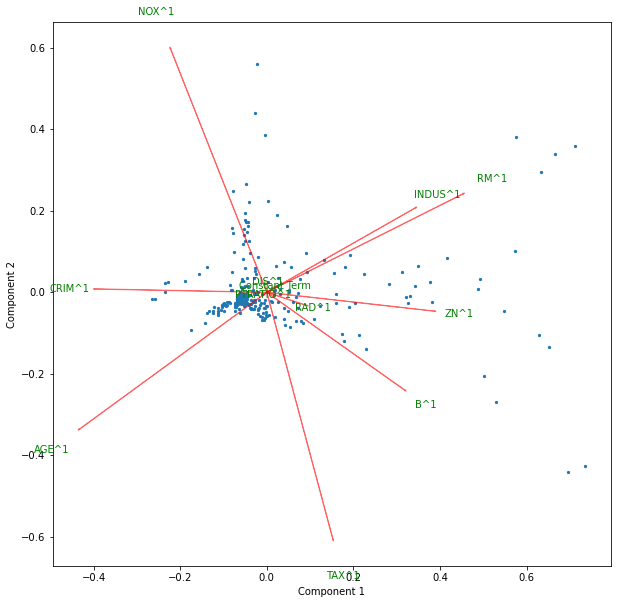

In [73]:
comp_ax_hor = 1

comp_ax_ver = 2

features_names = X_poly.columns

get_biplot(X_poly_pca,comp_ax_hor, comp_ax_ver, features_names)

# 2.5 Kernel PCA

This approach is equivalent to what we have done in 2.4: first we apply a transformation to the features and then we apply PCA. Kernel PCA does this automatically

In [98]:
def get_variance(X):
    
    variance = 0
    for i in range(X.shape[0]):
        
        for j in range(X.shape[1]):
            
            variance += X.values[i,j]**2
            
    variance /= X.shape[0]
            
    return variance

def get_kernel_pca(X,n_components, kernel, degree):
    
    pca = KernelPCA(n_components = n_components, kernel = kernel, degree = degree)

    pca.fit(X)

    X_pca = pca.fit_transform(X)

    X_pca = pd.DataFrame(X_pca)
    
    fn = []
    
    for i in range(n_components):
        
        fn.append('component ' + str(i + 1))
        
    X_pca.columns = fn
    

    pve = get_variance(X_pca)/get_variance(X) 
    

    print('Cumulative PVE: {:.1f} %'.format(pve*100))
    
    return X_pca, pca, pve


def get_scree_plot_kernel_pca(X,n_components,kernel,degree):
    
    cumulative_pve = np.zeros((len(n_components)))
    
    
    for i,n in enumerate(n_components):
        
        _, _, pve = get_kernel_pca(X,n, kernel, degree)

        cumulative_pve[i] += 100 * pve
        
    fig = plt.figure(figsize = (5,5))
        
    plt.plot(n_components, cumulative_pve,'bo-')
    plt.xlabel('N. components')
    plt.ylabel('Cumulative PVE')
    

Cumulative PVE: 2.4 %
Cumulative PVE: 5.4 %
Cumulative PVE: 6.1 %
Cumulative PVE: 6.4 %
Cumulative PVE: 6.6 %
Cumulative PVE: 6.6 %
Cumulative PVE: 6.7 %
Cumulative PVE: 6.7 %
Cumulative PVE: 6.8 %
Cumulative PVE: 6.8 %


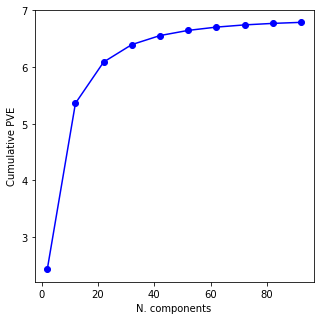

In [102]:
n_components = np.arange(2,100,10)

kernel = 'rbf'

degree = 2

get_scree_plot_kernel_pca(X_scaled_clean,n_components,kernel,degree)

In [107]:
n_components = 15

kernel = 'rbf'

degree = 3

X_kernel_pca, kernel_pca, kernel_pve = get_kernel_pca(X_scaled_clean, n_components,kernel,degree)


X_train, X_test, y_train, y_test = train_test_split(X_kernel_pca,y_clean, test_size = 0.33, random_state = 42)

lr = LinearRegression()

lr.fit(X_train,y_train)

adj_R2_train = get_adj_R2(lr, X_train, y_train)
adj_R2_test = get_adj_R2(lr,X_test, y_test)

print('')
print('Train adj R2 score: {:.3f}'.format(adj_R2_train))
print('Test adj R2 score: {:.3f}'.format(adj_R2_test))

Cumulative PVE: 5.7 %

Train adj R2 score: 0.848
Test adj R2 score: 0.817


In [108]:
X_kernel_pca

,component 1,component 2,component 3,component 4,component 5,component 6,component 7,component 8,component 9,component 10,component 11,component 12,component 13,component 14,component 15
0,0.181337,0.039701,0.399639,0.224841,-0.002303,-0.140791,-0.023597,-0.011410,0.012443,-0.117282,0.236625,-0.007254,0.068880,0.013895,0.005035
1,-0.099485,-0.258911,0.217744,0.128112,-0.132338,0.058498,-0.167740,-0.022726,0.116960,0.001981,0.007803,-0.067299,0.129503,-0.003009,0.032747
2,0.151011,-0.128758,0.423015,-0.191656,-0.016510,0.093708,-0.169814,-0.117347,0.093674,-0.007990,-0.072667,-0.040415,0.071844,0.021294,0.023583
3,0.302077,-0.213581,0.220153,-0.249344,-0.003537,0.208989,-0.073934,-0.184736,0.092996,-0.100697,0.048097,-0.029912,0.095620,0.127048,0.135054
4,0.251565,-0.191909,0.268515,-0.217481,-0.081687,0.238492,-0.111968,-0.202171,0.094528,-0.084069,0.025011,-0.024770,0.091025,0.084958,0.108804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,-0.396574,-0.077034,0.046315,-0.355009,-0.099684,-0.092566,0.064354,0.101422,0.024907,0.036389,-0.027704,-0.132420,0.079601,-0.012822,-0.144870
331,-0.471433,-0.070615,-0.047864,-0.282245,-0.117281,-0.128245,0.100210,0.115092,0.013900,0.011327,0.016719,-0.142000,0.105760,0.011533,-0.103835
332,-0.356947,0.093598,0.187379,-0.386737,-0.178916,-0.011502,-0.007916,0.149184,0.089022,-0.000762,-0.079940,-0.122407,0.106335,-0.028103,-0.166616
333,-0.391827,0.047482,0.142200,-0.370256,-0.185711,-0.034347,-0.002167,0.148238,0.085526,-0.004930,-0.053367,-0.145774,0.104560,-0.011707,-0.158522


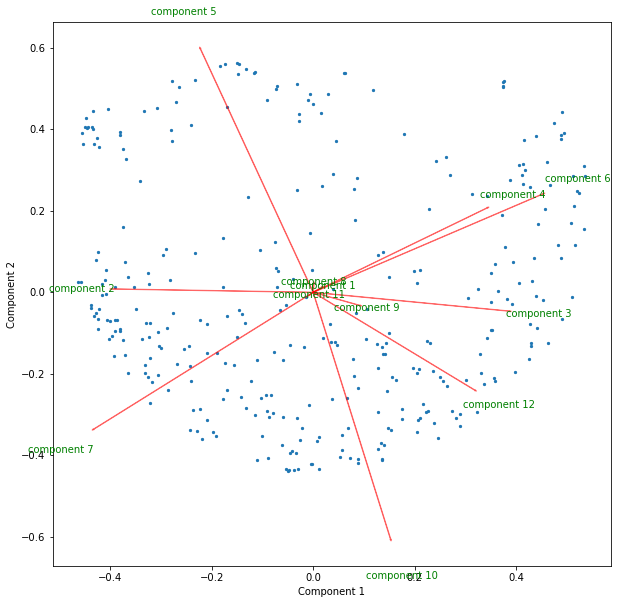

In [109]:
comp_ax_hor = 1

comp_ax_ver = 2

features_names = X_kernel_pca.columns

get_biplot(X_kernel_pca,comp_ax_hor, comp_ax_ver, features_names)